In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 520ms/step - loss: 0.2906 - root_mean_squared_error: 0.5390 - val_loss: 0.1866 - val_root_mean_squared_error: 0.4319
Epoch 2/50
53/53 [==============================] - 25s 482ms/step - loss: 0.1230 - root_mean_squared_error: 0.3507 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2891
Epoch 3/50
53/53 [==============================] - 25s 478ms/step - loss: 0.0760 - root_mean_squared_error: 0.2756 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2515
Epoch 4/50
53/53 [==============================] - 26s 501ms/step - loss: 0.0524 - root_mean_squared_error: 0.2289 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 5/50
53/53 [==============================] - 26s 495ms/step - loss: 0.0271 - root_mean_squared_error: 0.1648 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 6/50
53/53 [==============================] - 27s 513ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0106 

Epoch 37/50
53/53 [==============================] - 27s 509ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 38/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 39/50
53/53 [==============================] - 4s 70ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632
Epoch 40/50
53/53 [==============================] - 4s 70ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 41/50
53/53 [==============================] - 4s 70ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 42/50
53/53 [==============================] - 4s 70ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0046 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.55130285024643 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

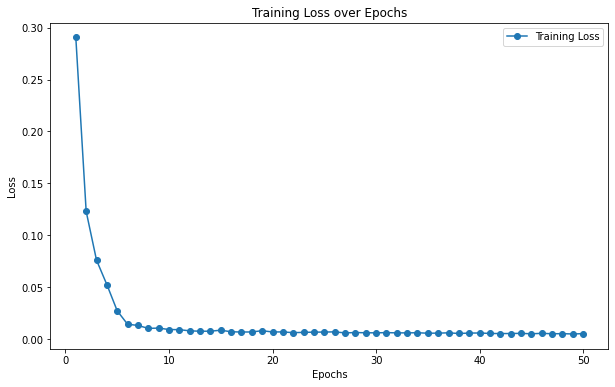

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

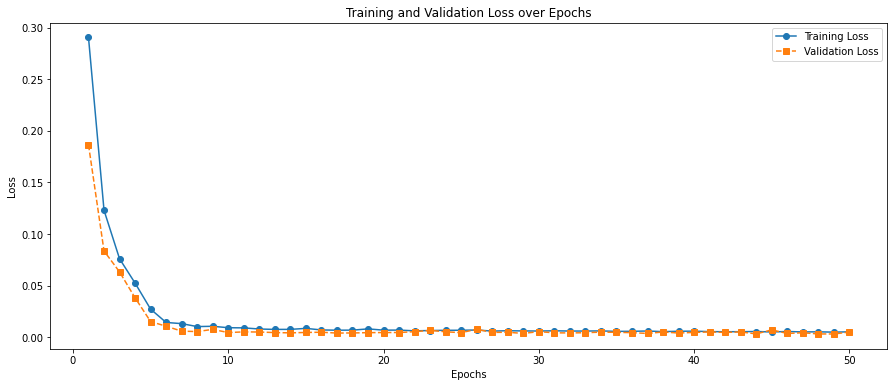

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 40ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.054685642659130194
MAE : 0.04456753352541576


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,4.280871e+06,4544849.638
1,5.238134e+06,5882741.038
2,5.901399e+06,6574288.749
3,6.146890e+06,6669726.076
4,6.056831e+06,6516136.854
5,5.442039e+06,5902163.675
6,3.698292e+06,3498103.449
7,1.267362e+06,1633675.726
8,9.031768e+05,1292668.399
9,1.246745e+06,1527666.815


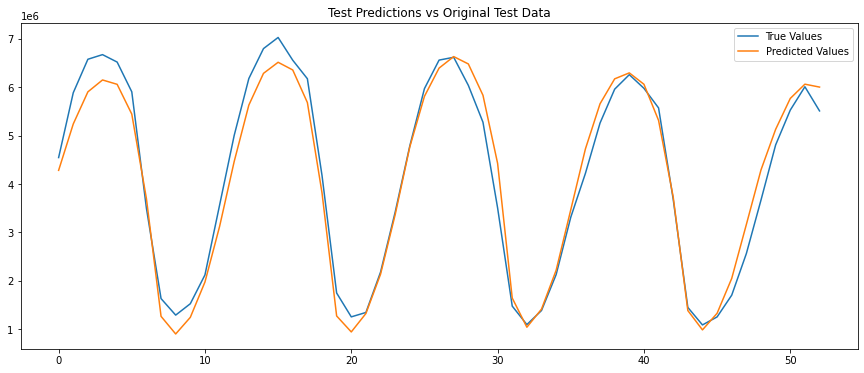

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 36ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

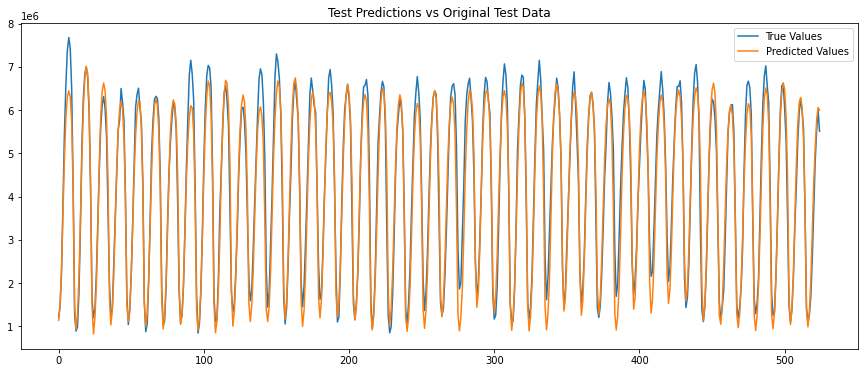

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()